#**Music Generator**

#Daniel Rodin and Tal Gottfeld Ben-Ze'ev

Project #5,
BootCamp,08/'21, 14.12.21

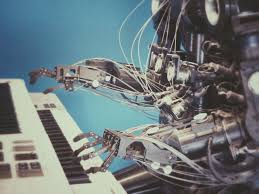

#1.Load and Process the Data

In [1]:
# Importing necessary libraries
from music21 import *
from music21 import converter, pitch, interval, duration, instrument, note, chord, stream, midi
from music21.metadata.bundles import MetadataEntry

# Access local library
import glob
import regex  

#Load into the environment. for listing down the file names
import os

#Array Processing
import numpy as np

In [2]:
# Connecting to google drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Defining the path to our midi files
my_path = '/gdrive/My Drive/DS/Projects/Project5/bach'
os.listdir(my_path)

[]

#2.Preprocessing

2.1 A function for preprocessing, which includes: parsing, separating to instruments and elements and inserting into a list of notes.

In [ ]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #Parsing a midi file
    midi = converter.parse(file)
  
    #Grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    for part in s2:
    
        #Select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
        
            #Finding whether a particular element is note or a chord
            for element in notes_to_parse:
                
                #Notes
                if isinstance(element, note.Note):
                    notes.append((str(element.pitch)+str(element.duration)))
                
                
                #Chords flatten to notes
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n)+str(element.duration) for n in element.normalOrder))

    return np.array(notes)

2.2 Iterating over each files and preprocess it with the above function.

In [ ]:
#Read all the filenames
files=[i for i in os.listdir(my_path) if i.endswith(".midi")]
print(files)

#Reading each midi file, parsing and converting it to an array of notes
songs_array = np.array([read_midi(my_path+'/'+i) for i in files])

[]


In [ ]:
# Importing a pickle file from google drive
import pickle 
DATA_PATH = '/gdrive/My Drive/DS/Projects/Project5/Pickel'
infile = open(DATA_PATH+'/notes_dur.pkl','rb')
songs_array = pickle.load(infile)

#3.Processing the Data for the Model

In [ ]:
#Converting 2D array into 1D array
songs_array_flat = [element for song in songs_array for element in song]

3.1 Preprocessing our data into a "readable" format for notes and chords.

In [ ]:
songs_array_new = []
for el in songs_array_flat:
    if el[0].isalpha():
        d = el.split('<')[0]+'_'+el.split(" ")[1][0:len(el.split(" ")[1])-1]
        songs_array_new.append(d)
    else:
        tt = [el.split('<m')[0]]
        cc = el.split('>')[0].split(' ')[-1]
        for i in el.split('>.')[1:]:
            tt.append(i.split('<m')[0])
            d = i
            # tt.append(i[-1].split(' ')[-1])
            
        c = '.'.join([str(elem) for elem in tt])+'_'+str(cc)
        songs_array_new.append(c)

3.2 Saving an object into a pickle

In [ ]:
# import pickle
# with open('notes.pkl', 'wb') as f:
#     pickle.dump(songs_array, f)

3.3 Loading an object from a pickle

In [ ]:
# import pickle
# with open(path, 'rb') as fid:
#      songs_array = pickle.load(fid)

In [ ]:
#No. of unique notes
unique_elements = list(set(songs_array_new))
print(len(unique_elements))

12127


3.4 Extracting frequent notes for training the model

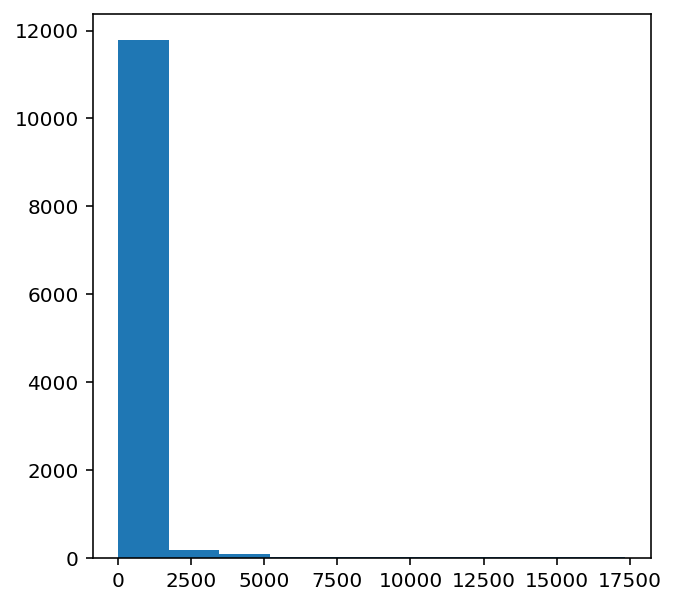

In [ ]:
#Importing library
from collections import Counter

#Computing frequency of each note
freq = dict(Counter(songs_array_new))

#Library for visualiation
import matplotlib.pyplot as plt

#Consider only the frequencies
no=[count for _,count in freq.items()]

#Set the figure size
plt.figure(figsize=(5,5))

#Plot
plt.hist(no);

3.5 Choosing how many of our frequent elements we want our model to study.

In [ ]:
frequent_elements = [note_ for note_, count in freq.items() if count>1]
print(len(frequent_elements))

1146


3.6 Inserting our elements into a numpy array

In [ ]:
new_music=[]
temp=[]
for element in songs_array_new:
    if element in frequent_elements:
        temp.append(element)            
new_music.append(temp)
    
new_music = np.array(new_music)

3.7 Defining the length of the sequence inserted into our model for prediction of the following note.

In [ ]:
no_of_timesteps = 20
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #Preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

3.8 Creating a dictionary to tokenize our notes and chords, along with their duration.

In [ ]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))
#We will prepare the integer sequences for input data

#Preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #Assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)


unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])


In [ ]:
#Let us preserve 80% of the data for training and the rest 20% for the evaluation:

from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq, y_seq, test_size=0.2, random_state=0)

#4.Defining our model and it's layers

In [ ]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
import tensorflow as tf

K.clear_session()
model = Sequential()
    
#Embedding layer
model.add(Embedding(len(unique_x), 100, input_length=no_of_timesteps,trainable=True)) 


model.add(Conv1D(128,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(32, 1)))


model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(AvgPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(AvgPool1D(1))
          
#model.add(Conv1D(256,5,activation='relu'))    
    
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(256, 1)))

# model.add(GlobalMaxPool1D())
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           114600    
                                                                 
 conv1d (Conv1D)             (None, 20, 128)           38528     
                                                                 
 dropout (Dropout)           (None, 20, 128)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 128)          0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 10, 64)           41216     
 l)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           2

4.1Defining a checkpoint for saving each step in the model's fit process.

In [ ]:
mc = ModelCheckpoint('best_model.h5', 
                    monitor='val_loss', 
                    mode='min', 
                    save_best_only=False,
                    verbose=1) 

In [ ]:
#Let’s train the model with a batch size of 64 for 50 epochs:

history = model.fit(np.array(x_tr),
                    np.array(y_tr),
                    batch_size=64,
                    epochs=50, 
                    validation_data=(np.array(x_val), np.array(y_val)),
                    verbose=1, 
                    callbacks=[mc])

In [ ]:
#Loading the last checkpoint:

# from keras.models import load_model
# model = load_model('best_model.h5')

#5.Deploy our Model

In [ ]:
# Its time to compose our own music now. We will follow the steps mentioned under the inference phase
#for the predictions.

import random
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]
predictions=[]
# Range of the output sequence:
for i in range(40):
  random_music = random_music.reshape(1, no_of_timesteps)

  prob = model.predict(random_music)[0]
  y_pred= np.random.choice(a=range(len(frequent_elements)), p=prob)
  predictions.append(y_pred)
# Choosing a randomized output from our predict proba:
  random_music = np.insert(random_music[0], len(random_music[0]), y_pred)
  random_music = random_music[1:]
    
print(predictions)

[202, 361, 1003, 757, 202, 1124, 1022, 900, 164, 361, 895, 930, 421, 164, 202, 1003, 1124, 884, 642, 1124, 884, 898, 1127, 189, 642, 405, 1003, 164, 719, 977, 977, 361, 164, 719, 78, 389, 757, 930, 928, 421]


In [ ]:
#Now, we will convert the integers back into the notes, using the dictionary created earlier:

x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [ ]:
# Converting a string fraction (14/3) into a float:

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac


#6.Converting the model results into midi file

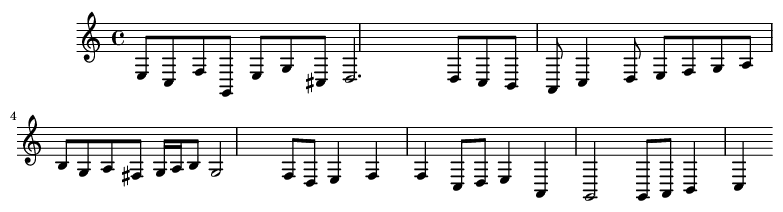

In [ ]:
#The final step is to convert back the predictions into a MIDI file. 
#Let’s define the function to accomplish the task.

def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # Create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        tav = pattern.split("_")[0]
        dur = pattern.split("_")[1]        
        # Note is a chord
        if ('.' in tav) or tav.isdigit():

            notes_in_chord = tav.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                new_note.duration = duration.Duration(convert_to_float(dur))
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # Pattern is a note
        else:
            new_note = note.Note(tav)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            new_note.duration = duration.Duration(convert_to_float(dur))
            output_notes.append(new_note)

        # Randomizing offset each iteration to make output music more fluid:
        offset += np.round(np.random.uniform(low=0.05, high=0.9), decimals=True)
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')
    # Displaying the notes of our prediction:
    show(midi_stream)

#Converting the predictions into a musical file:

convert_to_midi(predicted_notes)

Backup function to skip partition by instruments for single instrument midis. e.g. Bach files in 'Project5' folder or other music file you would like to use.

In [3]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    # s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    # for part in s2.parts:
    
    #     #select elements of only piano
    #     if 'Piano' in str(part): 
        
    notes_to_parse = midi.recurse() 

    #finding whether a particular element is note or a chord
    for element in notes_to_parse:
        
        #note
        if isinstance(element, note.Note):
            notes.append((str(element.pitch)+str(element.duration)))
        
        
        #chord
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n)+str(element.duration) for n in element.normalOrder))

    return np.array(notes)

Installing pretty midi, lilypond, IPython.display, musescore and fluidsynth in order to display the notes.

In [ ]:
print('installing lilypond...')
!apt-get install lilypond > /dev/null

print('installing musescore...')
!sudo apt-get install musescore

In [ ]:
pip install pretty_midi
from pretty_midi import *

ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [ ]:
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

import music21
from IPython.display import Image, Audio

def show(music):
    display(Image(str(music.write('lily.png'))))

def play(music):
    filename = music.write('mid')
    !fluidsynth -ni font.sf2 $filename -F $filename.wav -r 44100 > /dev/null
    # display(Audio(filename + '.wav'))

n = music21.note.Note('D#3')
n.duration.type = 'half'
play(n)
show(midi)

file = pretty_midi.PrettyMIDI(fn)